# Data Prerpocessing

## Import libraries

In [114]:
!pip install ta

  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29105 sha256=b6cf82af0eba585d0f22dd8fa8745ebce97ba4d0dafad7e0ea77b39cce4d9594
  Stored in directory: /Users/vomelenchuk/Library/Caches/pip/wheels/1b/81/50/db21d9643326c61dd6fee1dc2562d8351ee7753164c24ead38
Successfully built ta


In [74]:
import pandas as pd
import ta
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from statsmodels.tsa.api import VAR
from datetime import timedelta
import seaborn as sns
import re

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

## Reading the data

In [75]:
# bond yields
df = pd.read_csv('bond_yields.csv')
df['maturity(years)'] = df['sname'].apply(lambda x: int(re.match(r'(\d*).*', x).group(1)))
df['date'] = pd.to_datetime(df['date'])

# S&P500 index
sp500 = pd.read_csv('sp500.csv')
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500['Price'] = sp500['Price'].apply(lambda x: float(x.replace(',', '')))
sp500['Change %'] = sp500['Change %'].apply(lambda x: float(x.replace('%', '')))

# Macro indicators
gdp_df = pd.read_excel('gdp_unrate_usa.xlsx')

# merge macro indicators and yields
snames_df = pd.pivot_table(df, index=['date'], columns=['sname'], values='value', aggfunc=np.mean).reset_index()
df_var = pd.merge(gdp_df, snames_df, left_on='observation_date', right_on='date').drop('date', axis=1)
df_var['observation_date'] = pd.to_datetime(df_var['observation_date'])
df_var.set_index(df_var.columns[0], inplace=True, drop=True)

In [61]:
usa_dr = pd.read_csv('usa_discount_rate.csv')
usa_dr['Date'] = pd.to_datetime(usa_dr['Date'])
usa_dr.head()
#usa_dr['Close/Last']

,Date,Close/Last,Volume,Open,High,Low
0,2023-02-20,4.75,NaN,4.75,4.75,4.75
1,2023-02-17,4.75,NaN,4.75,4.75,4.75
2,2023-02-16,4.75,NaN,4.75,4.75,4.75
3,2023-02-15,4.75,NaN,4.75,4.75,4.75
4,2023-02-14,4.75,NaN,4.75,4.75,4.75


In [62]:
btc_df = pd.read_csv('BTC-USD.csv')
btc_df['Date'] = pd.to_datetime(btc_df['Date'])
btc_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-02-21,243.751999,255.320007,243.184006,244.533997,244.533997,12284200
1,2015-02-22,244.544006,246.391998,233.850998,235.977005,235.977005,19527000
2,2015-02-23,235.994995,240.108994,232.421005,238.891998,238.891998,16400000
3,2015-02-24,238.998001,239.901001,236.401993,238.735001,238.735001,14200400
4,2015-02-25,238.889999,239.339996,235.529999,237.470001,237.470001,11496200


# EDA

## Описова статистика

In [37]:
df.describe()

,value,maturity(years)
count,23745.000000,23745.000000
mean,1.730552,9.600000
std,1.173359,10.669808
min,0.041000,1.000000
25%,0.637000,2.000000
50%,1.701000,5.000000
75%,2.647000,10.000000
max,4.834000,30.000000


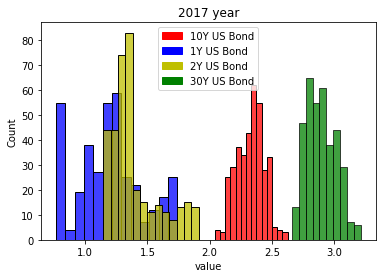

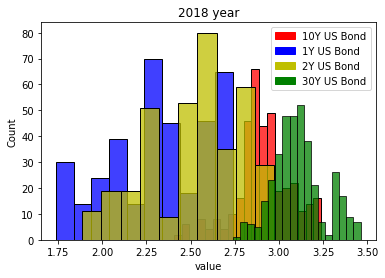

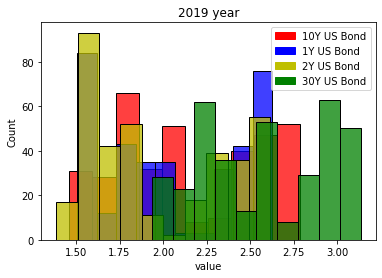

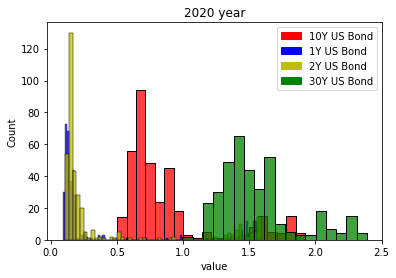

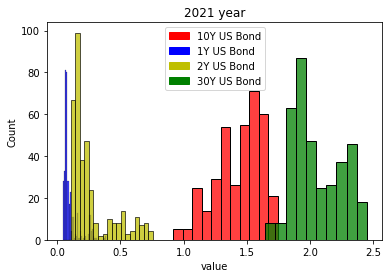

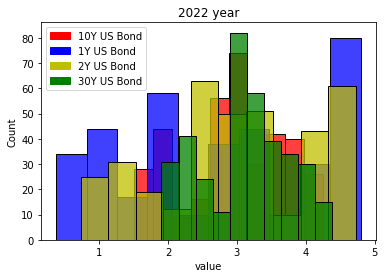

In [63]:
# Iterate over bond types and create histogram for each
for y in range(2017, 2023):
    # Subset data for bond type
    df1 = df[df['date'].dt.year==y]
    colors = {'10Y US Bond': 'r', '1Y US Bond': 'b', '2Y US Bond': 'y', '30Y US Bond': 'g'}
    labels = ['10Y US Bond', '1Y US Bond', '2Y US Bond', '30Y US Bond']

    for label in labels:
        sns.histplot(df1[df1['sname']==label]['value'], color=colors[label], label=label)

    # Create a custom legend based on the colors
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    plt.legend(handles, labels)

    # Show the plot
    plt.title(f"{y} year")
    plt.show()

На частотних гістограмах вище можна побачити розподіл дохідностей державних облігацій США за період з 2018 по 2022 роки. Можна спостерігати, що кожен вид облігації має свою дохідність і дисперсію, при цьому ситуація змінюється із року в рік. Наприклад, в 2021 році загалом зберігається тенденція, що чим більше термін погашення, тим більша дохідність. При цьому, в 2022 році, розподіл видів облігації по дохідності змішана, тобто навіть 1 і 2 річні облігації часто мають більшу дохідність, ніж 30, що може свідчити про наближення рецесії. Схожа ситуація була в 2019 році.

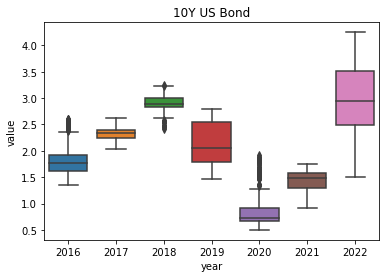

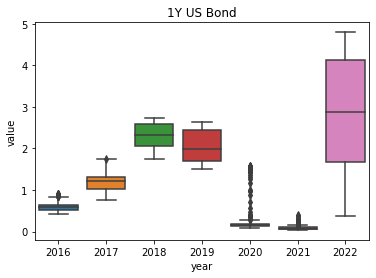

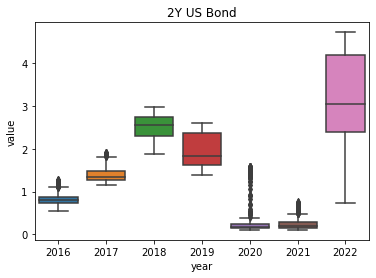

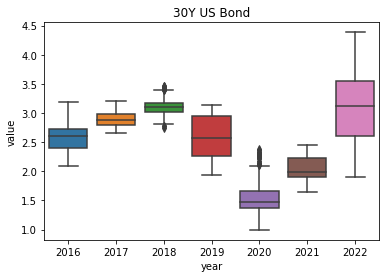

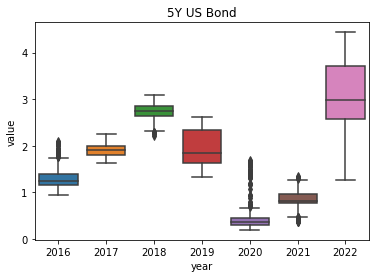

In [73]:
df['year'] = df['date'].dt.year

for bond in df['sname'].unique():
    plt.title(f'{bond}')
    sns.boxplot(x='year', y='value', data=df[(df['sname']==bond) & (df['year'] > 2015) & (df['year'] < 2023)])
    plt.show()

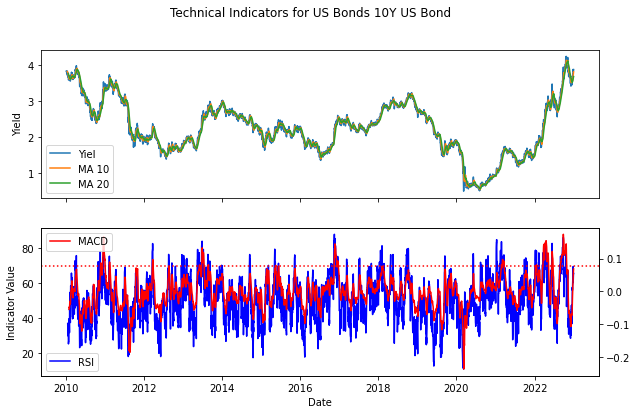

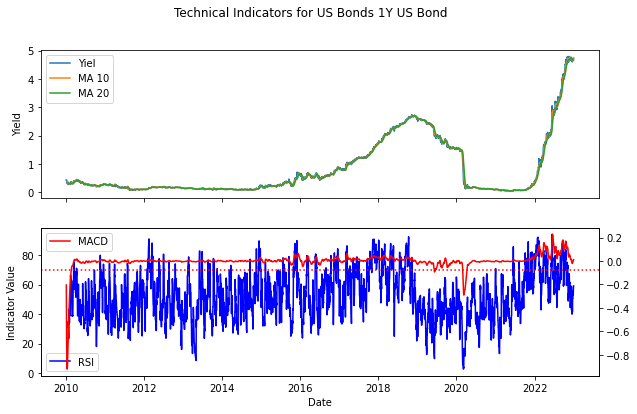

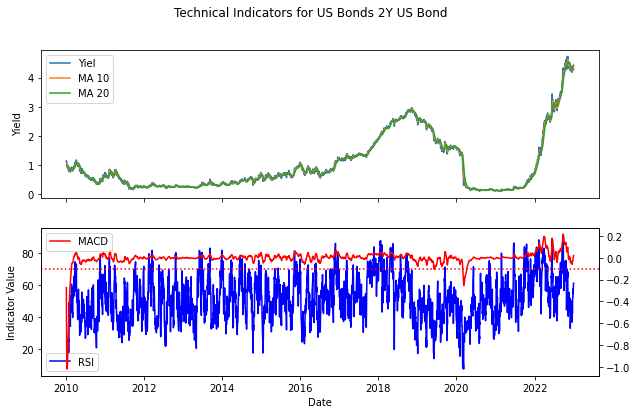

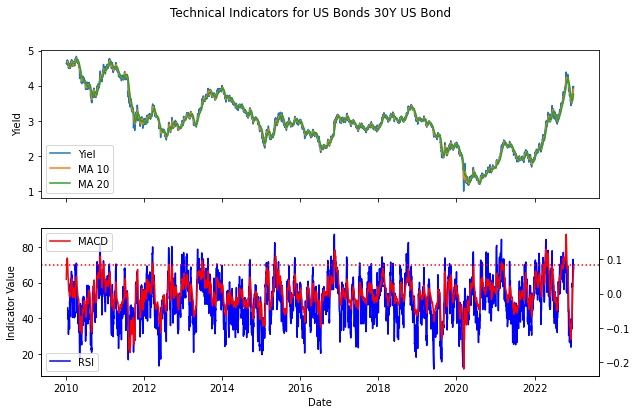

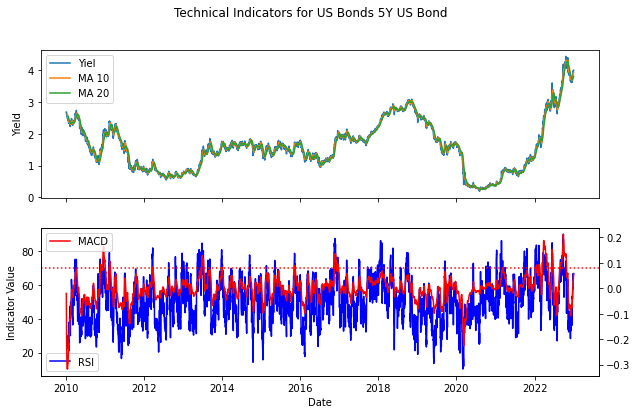

In [65]:
for bond in df['sname'].unique():
    df1 = df[df['sname'] ==bond].copy()
    # Add moving averages
    df1['ma_10'] = ta.trend.sma_indicator(df1['value'], window=10)
    df1['ma_20'] = ta.trend.sma_indicator(df1['value'], window=20)

    # Add relative strength index (RSI)
    df1['rsi'] = ta.momentum.RSIIndicator(df1['value'], window=14).rsi()

    # Add moving average convergence divergence (MACD)
    df1['macd'] = ta.trend.MACD(df['value']).macd()

    # Print the resulting DataFrame with technical indicators

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10, 6))

    # Plot the closing price and moving averages
    ax1.plot(df1['date'], df1['value'], label='Yiel')
    ax1.plot(df1['date'], df1['ma_10'], label='MA 10')
    ax1.plot(df1['date'], df1['ma_20'], label='MA 20')
    ax1.legend()

    # Plot the RSI and MACD
    ax_macd = ax2.twinx()
    ax2.plot(df1['date'], df1['rsi'], label='RSI', color='b')
    ax_macd.plot(df1['date'], df1['macd'], label='MACD', color='r')
    ax_macd.legend(loc='upper left')
    ax2.axhline(y=70, color='red', linestyle='dotted')

    ax2.legend(loc='lower left')

    # Set axis labels and title
    ax1.set_ylabel('Yield')
    ax2.set_ylabel('Indicator Value')
    ax2.set_xlabel('Date')
    fig.suptitle(f'Technical Indicators for US Bonds {bond}')

    plt.show()

RSI (індекс відносної сили) — це технічний індикатор моментуму, який використовується в аналізі фінансових ринків.

Індикатор RSI розраховується на основі середнього зростання та зниження ціни за визначений період (зазвичай 14 днів). Значення RSI коливається від 0 до 100, де значення вище 70 зазвичай вважаються перекупленими, а значення нижче 30 зазвичай вважаються перепроданими.

Індикатор RSI часто використовується трейдерами та інвесторами для виявлення потенційних розворотів трендів, а також для підтвердження сили існуючого тренду. Бичача дивергенція між RSI і ціною може свідчити про розворот тренду, тоді як ведмежа розбіжність може бути ознакою можливого розвороту тренда в протилежному напрямку. Однак, як і будь-який технічний індикатор, RSI не є надійним і його слід використовувати разом з іншими формами аналізу.


На графіку показано чотири технічні індикатори для набору даних облігацій США: 10-денне ковзне середнє (MA 10), 20-денне ковзне середнє (MA 20), індекс відносної сили (RSI) і розбіжність конвергенції ковзного середнього (MACD).

Верхній графік показує ціну закриття облігацій разом із двома ковзними середніми. MA 10 позначено помаранчевою лінією, а MA 20 – зеленою лінією. Графік показує, що дохідність, як правило, вище MA 10 і MA 20, що може вказувати на висхідний тренд.

Нижній графік показує індикатори RSI і MACD. RSI позначається синьою лінією, а MACD – помаранчевою лінією. RSI деякий час перевищує 70, що вказує на те, що облігації могли бути перекуплені. MACD загалом позитивний, що може бути ще одним свідченням висхідної тенденції.

Загалом графік показує, що облігації США, можливо, мали висхідний тренд протягом періоду набору даних, але з деякими періодами перекупленості.

In [66]:
# Різниця дохідності короткострокових та довгострокових бондів
df_rec = pd.DataFrame()
df_rec['date'] = list(dict.fromkeys(df['date']))
df_rec['10y_minus_1y'] = np.array(df.loc[df['sname']=='10Y US Bond', :]['value']) - np.array(df.loc[df['sname']=='1Y US Bond', :]['value'])

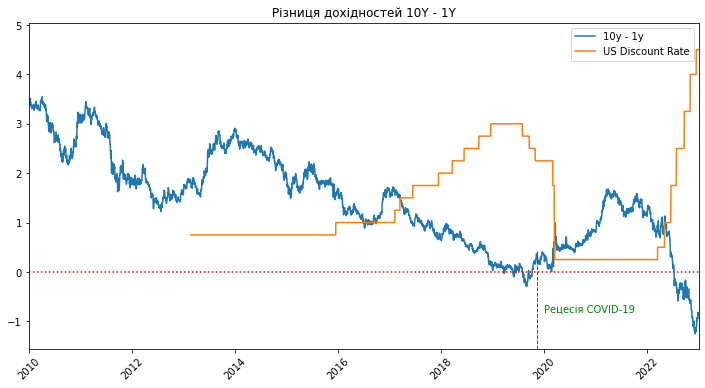

In [43]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.plot(df_rec['date'], df_rec['10y_minus_1y'], label = '10y - 1y')
ax.plot(usa_dr['Date'], usa_dr['Close/Last'], label='US Discount Rate')
ax.axhline(y=0, color='red', linestyle='dotted')
plt.title("Різниця дохідностей 10Y - 1Y")
plt.xlim(df_rec['date'].iloc[0], df_rec['date'].iloc[-1])
plt.xticks(rotation=45)
plt.axvline(x = df_rec['date'][3600], color = 'g', linestyle = 'dashed', linewidth=1, ymax=0.3)
plt.text(df_rec['date'][3650], -0.8, 'Рецесія COVID-19', color='green')
ax.legend()
ax.xaxis_date()

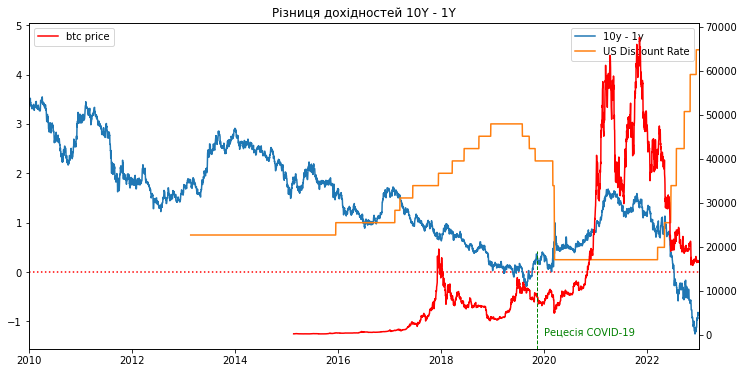

In [67]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax_btc = ax.twinx()
ax.axhline(y=0, color='red', linestyle='dotted')
ax.plot(df_rec['date'], df_rec['10y_minus_1y'], label = '10y - 1y')
ax.plot(usa_dr['Date'], usa_dr['Close/Last'], label='US Discount Rate')
ax_btc.plot(btc_df['Date'], btc_df['Close'], label='btc price', color='r')
plt.title("Різниця дохідностей 10Y - 1Y")
    plt.xlim(df_rec['date'].iloc[0], df_rec['date'].iloc[-1])
plt.xticks(rotation=45)
plt.axvline(x = df_rec['date'][3600], color = 'g', linestyle = 'dashed', linewidth=1, ymax=0.3)
plt.text(df_rec['date'][3650], -0.8, 'Рецесія COVID-19', color='green')
ax.legend()
ax_btc.legend()
ax.xaxis_date()

На графіку вище показано рецесію, яка була в США (джерело - https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States) і видно, що їй передував стан ринку облігацій, на якому дохідність довгих облігацій (10Y) менша за короткі (1Y). Поточна ситуація ринку демонструє, що в США скоріше за все очікується рецесія в 2023 році.

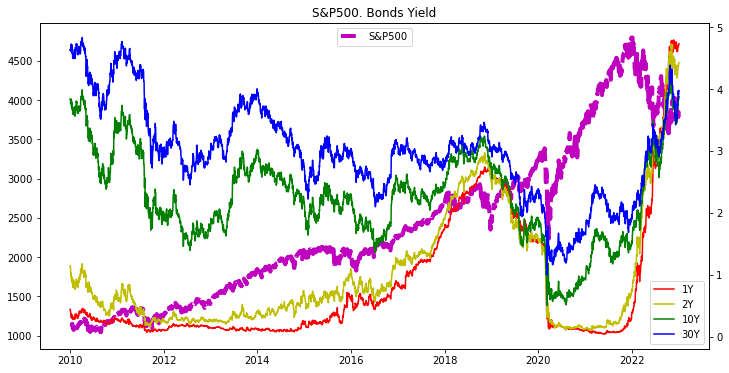

In [68]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.plot(sp500['Date'], sp500['Price'], color='m', label='S&P500', linestyle='dashed', linewidth=4)
ax.legend(loc='upper center')
ax_b= ax.twinx()
ax_b.plot(df[df['sname']=='1Y US Bond']['date'], df[df['sname']=='1Y US Bond']['value'], label='1Y', color='r')
ax_b.plot(df[df['sname']=='2Y US Bond']['date'], df[df['sname']=='2Y US Bond']['value'], label='2Y', color='y')
ax_b.plot(df[df['sname']=='10Y US Bond']['date'], df[df['sname']=='10Y US Bond']['value'], label='10Y', color='g')
ax_b.plot(df[df['sname']=='30Y US Bond']['date'], df[df['sname']=='30Y US Bond']['value'], label='30Y', color='b')
ax_b.legend()

plt.title("S&P500. Bonds Yield")
plt.xticks(rotation=45)
ax.xaxis_date()

Під час «рецесії COVID-19» у 2020 році ціни на облігації та акції рухалися в протилежних напрямках. Проте нинішнє падіння цін на акції також призвело до зниження цін на облігації. Це результат стримуючої монетарної та фіскальної політики для зниження високої інфляції. Ціни на облігації та прибутковість облігацій обернено пропорційні.

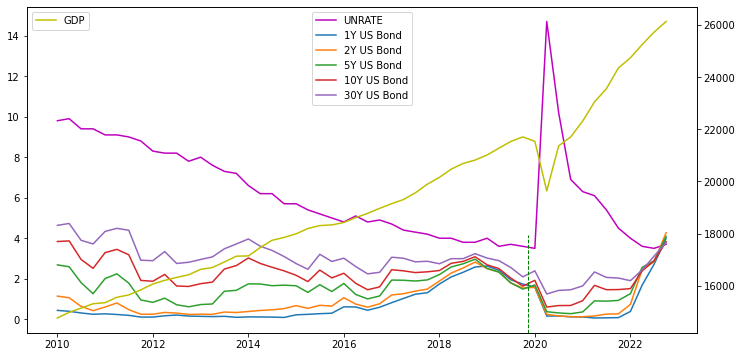

In [69]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax_b= ax.twinx()

ax.plot(df_var['UNRATE'], label='UNRATE', color='m')
ax.plot(df_var['1Y US Bond'], label='1Y US Bond')
ax.plot(df_var['2Y US Bond'], label='2Y US Bond')
ax.plot(df_var['5Y US Bond'], label='5Y US Bond')
ax.plot(df_var['10Y US Bond'], label='10Y US Bond')
ax.plot(df_var['30Y US Bond'], label='30Y US Bond')
ax.legend(loc='upper center')
plt.axvline(x = df_rec['date'][3600], color = 'g', linestyle = 'dashed', linewidth=1, ymax=0.3)
ax_b.plot(df_var['GDP'], label='GDP', color='y',)
ax_b.legend(loc='upper left')

Аналіз графіку прибутковості облігацій США, ВВП і рівня безробіття може дати деяке уявлення про те, як ці показники пов’язані один з одним.

Під час останньої рецесії 2020 року нижча дохідність облігацій відповідає нижчому економічному зростанню та вищому рівню безробіття. Це пояснюється тим, що коли дохідність облігацій низька, інвестори готові прийняти нижчу віддачу від своїх інвестицій, що може свідчити про відсутність довіри до економіки. Так само високий рівень безробіття може свідчити про слабше економічне зростання, що може призвести до зниження прибутковості облігацій. В 2023 році прогнозується несуттєве зниження ВВП та збільшення рівня безробіття, що матиме вплив на дохідність облігацій.


# Prediction model

## Predicting Yield Curve which describe current market situation

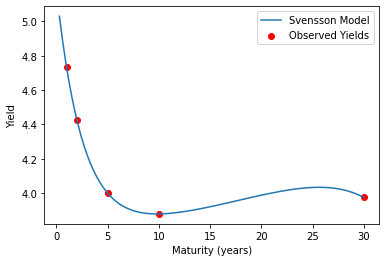

In [70]:
# Define the Svensson function
def svensson(params, t):
    beta0, beta1, beta2, beta3, lambda1, lambda2 = params
    return beta0 + beta1*(1-np.exp(-lambda1*t))/(lambda1*t) + beta2*((1-np.exp(-lambda1*t))/(lambda1*t) - np.exp(-lambda1*t)) + beta3*(1-np.exp(-lambda2*t))


year = 2023
month = 1
# Generate some sample data
maturity = np.array(df[(df['date'].dt.year == year) & (df['date'].dt.month == month)]['maturity(years)'])
yields = np.array(df[(df['date'].dt.year == year) & (df['date'].dt.month == month)]['value'])

# Define the initial values for the parameters
p0 = [0.03255560818769232, 0.027778738775706108, 0.04476740751765937, 0.07288674067225914, -0.03988642927583239, -0.06705186024528356]


#Define the constraints
# constraints = (
#     {'type': 'ineq', 'fun': lambda x: x[0]}, #beta0 > 0
#     {'type': 'ineq', 'fun': lambda x: x[1]-0.05}, #beta1 > 0.05
#     {'type': 'ineq', 'fun': lambda x: x[0]+x[1]-0.07}, #beta0 + beta1 > 0.07
#     {'type': 'ineq', 'fun': lambda x: x[2] + 1}, #beta2 > -1
#     {'type': 'ineq', 'fun': lambda x: x[3] + 1}, #beta3 > -1
#     {'type': 'ineq', 'fun': lambda x: x[4]}, #lambda1 > 0
#     {'type': 'ineq', 'fun': lambda x: x[5]}, #lambda2 > 0
# )

# Optimize the model
res = minimize(lambda params: np.sum((svensson(params, maturity) - yields)**2), p0, method='SLSQP') #, constraints=constraints

# Print the optimized parameters

# vizualization
# Generate a range of maturities for the curve
maturityv = np.linspace(0, 30, 100)

# Use the optimized parameters to predict the yields for each maturity
predicted_yields = svensson(res.x, maturityv)

# Plot the yield curve
#plt.title(f"Bond yields for {year} year and {month} month")
plt.plot(maturityv, predicted_yields, label='Svensson Model')
plt.scatter(maturity, yields, label='Observed Yields', color='r')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.legend()

plt.show()

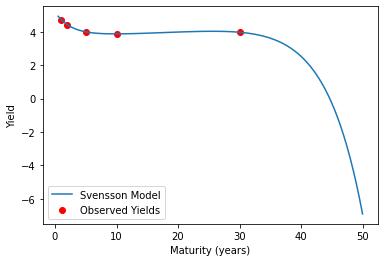

In [71]:
maturityv = np.linspace(0, 50, 100)

# Use the optimized parameters to predict the yields for each maturity
predicted_yields = svensson(res.x, maturityv)

plt.plot(maturityv, predicted_yields, label='Svensson Model')
plt.scatter(maturity, yields, label='Observed Yields', color='r')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.legend()

plt.show()

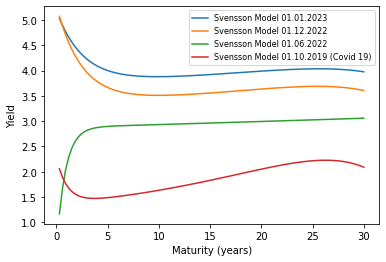

In [72]:
# Define the Svensson function
def svensson(params, t):
    beta0, beta1, beta2, beta3, lambda1, lambda2 = params
    return beta0 + beta1*(1-np.exp(-lambda1*t))/(lambda1*t) + beta2*((1-np.exp(-lambda1*t))/(lambda1*t) - np.exp(-lambda1*t)) + beta3*(1-np.exp(-lambda2*t))
p0 = [0.03255560818769232, 0.027778738775706108, 0.04476740751765937, 0.07288674067225914, -0.03988642927583239, -0.06705186024528356]

# Curve 01.01.2023
year = 2023
month = 1

# Generate some sample data
maturity = np.array(df[(df['date'].dt.year == year) & (df['date'].dt.month == month)]['maturity(years)'])
yields = np.array(df[(df['date'].dt.year == year) & (df['date'].dt.month == month)]['value'])

# Define the initial values for the parameters


# Optimize the model
res = minimize(lambda params: np.sum((svensson(params, maturity) - yields)**2), p0, method='SLSQP') #, constraints=constraints

# Print the optimized parameters

# vizualization
# Generate a range of maturities for the curve
maturityv = np.linspace(0, 30, 100)

# Use the optimized parameters to predict the yields for each maturity
predicted_yields = svensson(res.x, maturityv)

# Plot the yield curve
#plt.title(f"Bond yields for {year} year and {month} month")
plt.plot(maturityv, predicted_yields, label='Svensson Model 01.01.2023')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.legend()

# Curve 01.12.2022
year = 2022
month = 12
# Generate some sample data
maturity = np.array(df[(df['date'].dt.year == year) & (df['date'].dt.month == month) & (df['date'].dt.day == 1)]['maturity(years)'])
yields = np.array(df[(df['date'].dt.year == year) & (df['date'].dt.month == month) & (df['date'].dt.day == 1)]['value'])

# Optimize the model
res = minimize(lambda params: np.sum((svensson(params, maturity) - yields)**2), p0, method='SLSQP') #, constraints=constraints

# Print the optimized parameters

# vizualization
# Generate a range of maturities for the curve
maturityv = np.linspace(0, 30, 100)

# Use the optimized parameters to predict the yields for each maturity
predicted_yields = svensson(res.x, maturityv)

# Plot the yield curve
#plt.title(f"Bond yields for {year} year and {month} month")
plt.plot(maturityv, predicted_yields, label='Svensson Model 01.12.2022')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.legend()

# Curve 01.06.2022

year = 2022
month = 6
# Generate some sample data
maturity = np.array(df[(df['date'].dt.year == year) & (df['date'].dt.month == month) & (df['date'].dt.day == 1)]['maturity(years)'])
yields = np.array(df[(df['date'].dt.year == year) & (df['date'].dt.month == month) & (df['date'].dt.day == 1)]['value'])

# Optimize the model
res = minimize(lambda params: np.sum((svensson(params, maturity) - yields)**2), p0, method='SLSQP') #, constraints=constraints

# Print the optimized parameters

# vizualization
# Generate a range of maturities for the curve
maturityv = np.linspace(0, 30, 100)

# Use the optimized parameters to predict the yields for each maturity
predicted_yields = svensson(res.x, maturityv)

# Plot the yield curve
#plt.title(f"Bond yields for {year} year and {month} month")
plt.plot(maturityv, predicted_yields, label='Svensson Model 01.06.2022')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.legend()

# Curve 01.06.2022

year = 2019
month = 10
# Generate some sample data
maturity = np.array(df[(df['date'].dt.year == year) & (df['date'].dt.month == month) & (df['date'].dt.day == 1)]['maturity(years)'])
yields = np.array(df[(df['date'].dt.year == year) & (df['date'].dt.month == month) & (df['date'].dt.day == 1)]['value'])

# Optimize the model
res = minimize(lambda params: np.sum((svensson(params, maturity) - yields)**2), p0, method='SLSQP') #, constraints=constraints

# Print the optimized parameters

# vizualization
# Generate a range of maturities for the curve
maturityv = np.linspace(0, 30, 100)

# Use the optimized parameters to predict the yields for each maturity
predicted_yields = svensson(res.x, maturityv)

# Plot the yield curve
#plt.title(f"Bond yields for {year} year and {month} month")
plt.plot(maturityv, predicted_yields, label='Svensson Model 01.10.2019 (Covid 19)')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.legend(fontsize = '8')

plt.show()

Для кращого розуміння ринку облігацій використовується модель Свенссона. По ній можна визначати ріст економіки або рецесію. Якщо крива висхідна - очікується ріст, навпаки - рецесія. Як видно по графіку вище, під час появи перших нових про КОВІД 19 і в кінці 2022, початку 2023 року криві схожі - мають нисхідний характер, що може свідчити про майбутню рецесію.

Основна перевага моделі Свенссона полягає в тому, що вона відносно проста у використанні та може точно передбачити форму кривої дохідності в широкому діапазоні строків погашення. Це робить її цінним інструментом для фінансових аналітиків та інвесторів, які намагаються спрогнозувати майбутні ринкові тенденції.

Одним із недоліків моделі Свенссона є те, що вона не завжди може точно відображати справжню базову динаміку ринку облігацій. У деяких випадках модель може давати результати, які суперечать іншим ринковим даним, що може призвести до неточних прогнозів. Крім того, модель припускає, що відсоткові ставки визначаються фіксованим набором параметрів, що не завжди має місце в ринковому середовищі, яке швидко змінюється.

Загалом модель Свенссона є корисним інструментом для аналізу кривої прибутковості та прогнозування майбутніх ринкових тенденцій. Однак її слід використовувати в поєднанні з іншими ринковими даними та аналітичними інструментами, щоб переконатися, що її прогнози є максимально точними та надійними.

Для кращої оптимізації моделі потрібно протестувати наступні параметри:

1. Початкові коефіцієнти моделі Свенссона. Оскільки алгоритм мінімізації помилки починає підбір параметрів саме з тих, які ми вказали на початку, є сенс підбору цих параметрів для знаходження глобального мінімімуму.
2. Алгоритм мінімізації. Кожен алгоритм працює по-своєму і має різні результати

Оцінка точності моделі - сума квадратів помилки (yield real - yield predicted)

### Svensson model testing

In [206]:
df = pd.read_csv('bond_yields.csv')
df['maturity(years)'] = df['sname'].apply(lambda x: int(re.match(r'(\d*).*', x).group(1)))
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] == df['date'].max()]

maturity = np.array(df['maturity(years)'])
yields = np.array(df['value'])

In [191]:
all_results = []
min_methods = ['Nelder-Mead', 'Powell', 'BFGS',
               'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP']

for i in tqdm(range(1000), position=0, leave=True):
    # Generate some sample data
    
    one_result = {}
    p0 = [random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.3)]
    # Optimize the model
    for method in min_methods:
        #print(method)
        res = minimize(lambda params: np.sum((svensson(params, maturity) - yields)**2), p0, method=method) #, constraints=constraints

        # Print the optimized parameters
        # Use the optimized parameters to predict the yields for each maturity
        predicted_yields = svensson(res.x, maturity)
        one_result['method'] = method
        one_result['p0'] = p0
        one_result['sq_errors'] = sum((df['value'] - svensson(res.x, df['maturity(years)']))**2)
        all_results.append(one_result)

 31%|███       | 307/1000 [02:21<05:20,  2.16it/s]


KeyboardInterrupt: 

In [51]:
res_df = pd.DataFrame(all_results)
res_df = res_df.sort_values(by='sq_errors', ascending=True).reset_index(drop=True)
res_df

NameError: name 'all_results' is not defined

In [194]:
res_df['p0'][0], res_df['method'][0]

([0.03255560818769232,
  0.027778738775706108,
  0.04476740751765937,
  0.07288674067225914,
  -0.03988642927583239,
  -0.06705186024528356],
 'SLSQP')

In [50]:
# Define the initial values for the parameters
p0 = res_df['p0'][0]


#Define the constraints
# constraints = (
#     {'type': 'ineq', 'fun': lambda x: x[0]}, #beta0 > 0
#     {'type': 'ineq', 'fun': lambda x: x[1]-0.05}, #beta1 > 0.05
#     {'type': 'ineq', 'fun': lambda x: x[0]+x[1]-0.07}, #beta0 + beta1 > 0.07
#     {'type': 'ineq', 'fun': lambda x: x[2] + 1}, #beta2 > -1
#     {'type': 'ineq', 'fun': lambda x: x[3] + 1}, #beta3 > -1
#     {'type': 'ineq', 'fun': lambda x: x[4]}, #lambda1 > 0
#     {'type': 'ineq', 'fun': lambda x: x[5]}, #lambda2 > 0
# )

# Optimize the model
res = minimize(lambda params: np.sum((svensson(params, maturity) - yields)**2), p0, method=res_df['method'][0]) #, constraints=constraints

# Print the optimized parameters
print(res.x)

# vizualization
# Generate a range of maturities for the curve
maturityv = np.linspace(0, 30, 100)

# Use the optimized parameters to predict the yields for each maturity
predicted_yields = svensson(res.x, maturityv)

print(f"Sum of squared errors: {sum((df['value'] - svensson(res.x, df['maturity(years)']))**2)}")

# Plot the yield curve
plt.plot(maturityv, predicted_yields, label='Svensson Model')
plt.scatter(df['maturity(years)'], df['value'], label='Observed Yields', color='r')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.legend()
plt.show()

NameError: name 'res_df' is not defined

## Predicting Yield Curve for future

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Load data
df = pd.read_csv('bond_yields.csv')
df = df[df['sname']=='10Y US Bond']
# Prepare data
x = df['value'].values
x = np.reshape(x, (-1, 1)).astype(np.float32)

# Normalize data
mean = np.mean(x)
std = np.std(x)
x = (x - mean) / std

# Define dataset class
class BondDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+self.seq_len]
        return x, y

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=2):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define training function
def train(model, dataloader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))

# Set hyperparameters
seq_len = 5
input_size = 1
hidden_size = 16
num_layers = 6
learning_rate = 0.001
batch_size = 32
epochs = 100

# Prepare data for training
dataset = BondDataset(x, seq_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, loss function, and optimizer
model = LSTM(input_size, hidden_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train model
train(model, dataloader, optimizer, criterion, epochs)

# Prepare data for prediction
x_pred = x[-seq_len:]
x_pred = np.reshape(x_pred, (1, seq_len, input_size))
x_pred = torch.from_numpy(x_pred).to(device)

# Predict future values
model.eval()

# Denormalize data
x = x * std + mean

# Predict future values
model.eval()
with torch.no_grad():
    predictions = []
    for i in range(500):
        y_pred = model(x_pred).item()
        x_pred = torch.cat((x_pred[:, 1:, :], torch.tensor([[[y_pred]]]).to(device)), axis=1)
        predictions.append(y_pred)

# Denormalize predictions
predictions = np.array(predictions)
predictions = predictions * std + mean

# Plot actual values and predicted values
plt.plot(df['value'], color='blue', label='Actual')
plt.plot(range(len(df), len(df)+500), predictions, color='red', label='Predicted')
plt.title('Bond Yield Prediction')
plt.xlabel('Time')
plt.ylabel('Yield')
plt.legend()
plt.show()

Epoch [1/100], Loss: 0.6064
Epoch [2/100], Loss: 0.0066


KeyboardInterrupt: 

# VAR з прогнозними значеннями

<AxesSubplot:>

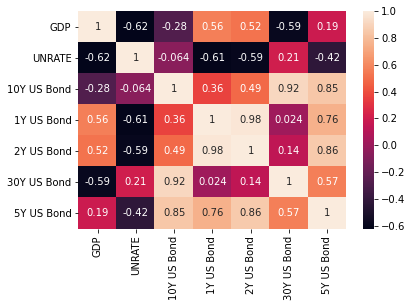

In [53]:
sns.heatmap(df_var.corr(), annot=True)

In [54]:
all_gdp_forecast = []
gdp_last = 26132.458
for i in [-0.6, -2, -0.7, 1]:
    gdp_last *= i/100 + 1
    all_gdp_forecast.append(gdp_last)

all_unrate_forecast = [3.7, 3.8, 4, 4.2]

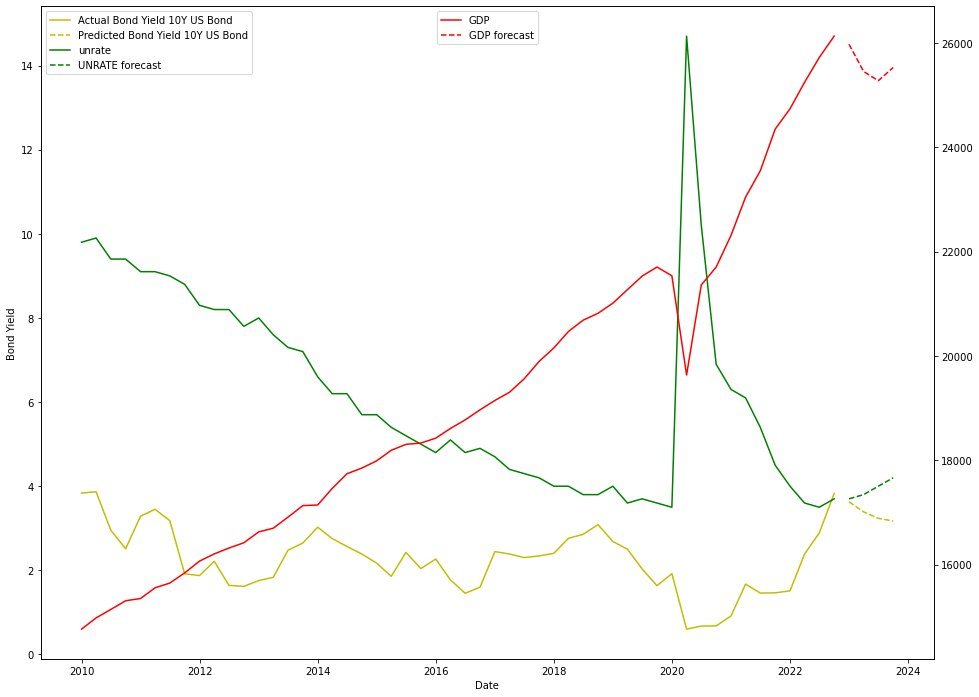

In [55]:
#VAR з прогнозними значеннями
bcolors = dict(zip(df['sname'].unique(), ['y', 'b', 'k', 'm', 'c']))

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot()

for bond in df['sname'].unique():

    # Define the variables
    vars = [bond, 'GDP', 'UNRATE']

    # Estimate the VAR model
    model = VAR(df_var[vars], exog=df_var[['GDP', 'UNRATE']])
    results = model.fit()


    # Forecasts
    # GDP taken from https://www.conference-board.org/research/us-forecast#:~:text=We%20forecast%20that%20real%20GDP,recession%20starting%20in%20Q1%202023.
    # unemployment rate taken from https://tradingeconomics.com/united-states/unemployment-rate?embed/forecast

    forecasts = [list(x) for x in list(zip(all_gdp_forecast, all_unrate_forecast))]
    forecast = results.forecast(df_var[vars].values[-results.k_ar:], steps=4, exog_future=forecasts)

    # Create plot of actual vs predicted values

    pred_index = pd.date_range(start=df_var.index[-1], periods=len(forecast)+1, freq='QS')[1:]
    # Plot the bond yield and GDP
    ax_gdp = ax.twinx()
    ax.plot(df_var[bond], label=f'Actual Bond Yield {bond}', color=bcolors[bond])
    # ax.plot(df_var['UNRATE'], label='unrate', color='g')
    # ax.plot(pd.DataFrame(data={'forecast': [x[1] for x in forecasts]}, index=pred_index), label='UNRATE forecast', color='g', linestyle='--')
    ax_gdp.plot(df_var['GDP'], label='GDP', color='r')
    ax_gdp.plot(pd.DataFrame(data={'forecast': [x[0] for x in forecasts]}, index=pred_index), label='GDP forecast', color='r', linestyle='--')

    # Create a DataFrame with predicted values and corresponding index

    pred_df = pd.DataFrame(data={'forecast': forecast[:,0]}, index=pred_index)
    # Concatenate the actual and predicted values DataFrames
    combined_df = pd.concat([df_var, pred_df], axis=0)
    # Plot the predicted values
    ax.plot(combined_df['forecast'], label=f'Predicted Bond Yield {bond}', linestyle='--', color=bcolors[bond])
    ax.legend(loc='upper left')
    ax_gdp.legend(loc='upper center')
    #ax.set_title(f'Actual vs Predicted Bond Yield {bond}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Bond Yield')

ax.plot(df_var['UNRATE'], label='unrate', color='g')
ax.plot(pd.DataFrame(data={'forecast': [x[1] for x in forecasts]}, index=pred_index), label='UNRATE forecast', color='g', linestyle='--')    
ax.legend(loc='upper left')
plt.show()

In [56]:
model.fit().summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 23, Feb, 2023
Time:                     16:44:35
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -111.386
Nobs:                     51.0000    HQIC:                  -111.807
Log likelihood:           2658.62    FPE:                2.14360e-49
AIC:                     -112.067    Det(Omega_mle):     1.53543e-49
--------------------------------------------------------------------
Results for equation 10Y US Bond
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.626124         1.024122            0.611           0.541
GDP                    0.000178         0.000369            0.481           0.631
UNRATE                -0.077578         0.077148  

Дивлячись на коефіцієнти для рівняння 5-річних облігацій США, ми бачимо, що лагована величина самих 5-річних облігацій США (L1,5Y облігацій США) має найвищий коефіцієнт, який вказує на те, що найбільш значущим показником дохідності 5-річних облігацій США є власне відстаюче значення. Це має сенс, оскільки на дохідність облігацій часто впливають минулі тенденції та очікування ринку.

Коефіцієнти для інших змінних (ВВП і рівень безробіття) відносно малі, що вказує на те, що їхній вплив на дохідність 5-річних облігацій США не такий значний. P-значення для цих коефіцієнтів також відносно високі, що вказує на те, що вони можуть бути статистично незначимими.

Кореляційна матриця показує, що існує помірна позитивна кореляція (0,55) між ВВП і прибутковістю 5-річних облігацій США та слабка негативна кореляція (-0,0033) між UNRATE і прибутковістю 5-річних облігацій США.

------------------------------------------------------------------------------------------------------------

Для прогнозування в майбутньому використано модель VAR. Обрав її оскільки вона допомагає прогнознувати значення виходячи з інших незалежних змінних, по яким в нас є прогноз. В нашому випадку, у нас є прогноз на 4 періоди вперед по ВВП та % безробіття (макропоказники, які корелюють з дохідністю по обгіаціям).

Векторна авторегресія (VAR) — це статистична модель, яка використовується для аналізу зв’язку між двома чи більше змінними з часом.

Переваги використання моделі VAR:

1) Кілька змінних можна аналізувати одночасно: VAR може фіксувати динамічні зв’язки між кількома змінними часових рядів, що особливо корисно в економічних і фінансових прогнозах, коли діють численні фактори.
2) Може фіксувати цикли зворотного зв’язку: VAR здатний фіксувати цикли зворотного зв’язку, які існують між різними змінними. Це важливо, оскільки зв’язок між двома змінними може змінюватися з часом, а цикли зворотного зв’язку можуть посилювати або послаблювати вплив певних потрясінь.
3) Гнучкість: моделі VAR можна використовувати для моделювання різних типів зв’язків між змінними. Він може моделювати миттєві або відсталі ефекти, і його можна використовувати для моделювання як стаціонарних, так і нестаціонарних часових рядів.

Однак використання моделі VAR також має деякі мінуси:

1) Прокляття розмірності: VAR може стати інтенсивним обчисленням, коли мається на увазі велика кількість змінних. Чим більше є змінних, тим більше параметрів потрібно оцінити, і тим важче може бути виявити зв’язки між ними.
2) Припускає лінійність: VAR припускає, що зв’язок між змінними є лінійним, що не завжди відповідає дійсності. Нелінійні зв’язки між змінними можуть бути краще охоплені іншими моделями.
3) Потрібен стаціонарний часовий ряд: VAR передбачає, що часовий ряд є стаціонарним. Якщо дані не є стаціонарними, їх потрібно буде трансформувати перед застосуванням моделі, що може зайняти багато часу, а також створити додаткові помилки.